## Training a semantic classifier with Reddit data

The following code pulls the 1000 newest posts from each designated subreddit, vectorizes each post and uses logistic regression to predict the subreddit of origin.

In [1]:
import praw

# Each subreddit 
subreddits = [
    'astrology',
    'chemistry',
    'mathematics',
    'datascience',
    'standup', 
    'conspiracy'
] 


# Instantiate reddit object
reddit = praw.Reddit(
    client_id='my_id',
    client_secret='my_secret',
    user_agent = 'Reddit Scraper'
)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Instantiate lists
all_posts, sub_labels = list(), list()

# Loop over list of subreddits
for i, sub in enumerate(subreddits):
    
    # Get text from 25000 latest posts
    subreddit_data = reddit.subreddit( sub ).new( limit = 25000 )
    
    # Limit to those at least 80 alphabetic characters
    posts = [post.selftext for post in subreddit_data if len(re.sub('\W|\d', '', post.selftext)) >= 80]

    # Add posts/labels to respective lists, print after success
    all_posts += posts
    sub_labels += [i] * len(posts) 
    print("number of posts from {}: ".format(sub),len(posts)) 

number of posts from astrology:  548
number of posts from chemistry:  595
number of posts from mathematics:  817
number of posts from datascience:  701
number of posts from standup:  675
number of posts from conspiracy:  456


#### Visually analyze how the posts are distributed


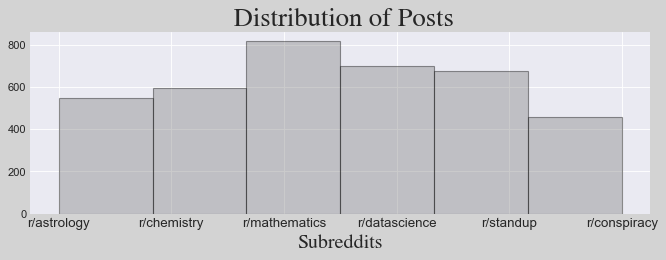

In [6]:
# Set sytle
plt.style.use('seaborn-darkgrid')

# Plot distribution of labels
plt.figure(figsize = (2*len(subreddits)-2,int(len(subreddits)/2)), dpi=80, facecolor='lightgray')
plt.hist(np.array(sub_labels), bins = len(subreddits),color='grey', alpha = 0.4, edgecolor='k') 
plt.title(" Distribution of Posts", size = 24,  fontname='Times')
plt.xlabel("Subreddits", size=18,  fontname='Times')
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 

plt.show() 

#### Data Preprocessing

We clean our text data in the following ways:
- Break the post into individual words, removing not alphabetic characters and URL-like strings
- Lemmatize the words so we weight the same concepts equally ("playing" = "plays" = "played")
- Remove 1-letter words and 'stop words' that do not convey meaning in the text ("i", "a", "be", "in")

In [4]:
# Natural Language Tool Kit and several preprocessing methods
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk


def my_prep(doc):
    """ Remove all non alphabetic characters/URL-like strings """
    return re.sub('\W|\d|http\S+|www\S+',' ',doc)


def my_toke(text):
    """ Break our post into tokens then lemmatize """
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word not in stopwords.words('english') and len(word)>1]
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    return lemmas


# Comparing raw text data from reddit post to list of tokens
print("Before: ",re.sub('\n','  ',all_posts[0][:200]))
print("\nAfter: ",my_toke(my_prep(all_posts[0]))[:20]) 

BEFORE: 
I'm somewhat new to this stuff and have always been a bit on the skeptical side when it comes to astrology.  As I've delved more into occult topics the past few years, the idea that science is only on ... 

AFTER: 
 ['somewhat', 'new', 'stuff', 'always', 'bit', 'skeptical', 'side', 'come', 'astrology', 'a', 'delved', 'occult', 'topic', 'past', 'year', 'idea', 'science', 'one', 'side', 'coin']


#### Vectorizing the text data
Using tf-idf ensures that the vocabulary specific to each subreddit are not drowned out by words that are frequently used across all subreddits.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer



# Use our predefined functions to clean the data
vectorizer = TfidfVectorizer(preprocessor = my_preprocessor, min_df = 1)

X = vectorizer.fit_transform(all_posts)

In [6]:
X

<3817x19940 sparse matrix of type '<class 'numpy.float64'>'
	with 191069 stored elements in Compressed Sparse Row format>

Above, we see our matrix $\mathbf{X}$ is huge and sparsely populated. Many models work poorly with sparse data, so `TruncatedSVD` is used to find a low rank approximation to the original term-document matrix.

Through optimization, the number of data features which maximize classifier accuracy was found to be `n_components = 170`

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# Reduce number of features in the data to 170
tsvd = TruncatedSVD(n_components = 170, n_iter = 10)


# Reduced matrix
X_reduced = tsvd.fit_transform(X)


#### Fitting a Logistic Regression Classifier to the reduced data

To reliably measure the classifier's accuracy, `X_reduced` must be split into training and validation sets, ensuring the test is based on novel data.



In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data with test size of 5%, with random_state=0 so the results are reproducible
X_train, X_test, y_train, y_test = train_test_split(X_reduced, sub_labels, test_size = 0.05, random_state = 0) 

print("{} documents selected for validation set".format(len(y_test)))


The model is fit and scored using `sklearn.metrics.accuracy_score`

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


# Instantiate model
lrcv = LogisticRegressionCV(
    multi_class='auto', 
    max_iter=200, 
    cv=5, 
    n_jobs=-1
)

# Fit model to the data and make predictions
lrcv.fit(X_train,y_train) 
predict = lrcv.predict(X_test)

# Measure the accuracy of our model
acc = accuracy_score(predict, y_test) 

print("Accuracy: ", str(acc)[:8])

#### Visual analysis should be more telling than a numerical score:

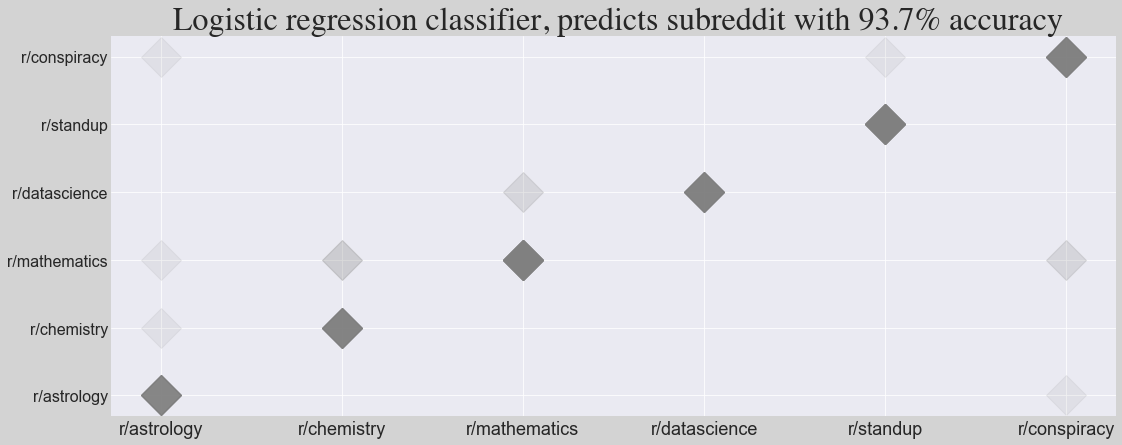

In [16]:

# Plot the predictions as a function of true label
plt.figure(figsize = (3*len(subreddits), len(subreddits)+1), facecolor='lightgray')
plt.title(" Logistic regression classifier, predicts subreddit with {}% accuracy".format(round(acc*100, 1)), fontsize='32', fontname='Times')
plt.scatter(y_test, predict, alpha = 0.1, s = 800, marker = 'D', c='grey')
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=18) 
plt.yticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=16)

plt.show()

At nearly 90% accuracy, this classifier has done remarkably considering how little data was required to train it (less than 4000 samples with only 170 features)

To gauge the accuracy by individual subreddit, let's examine the predictions made for each label:

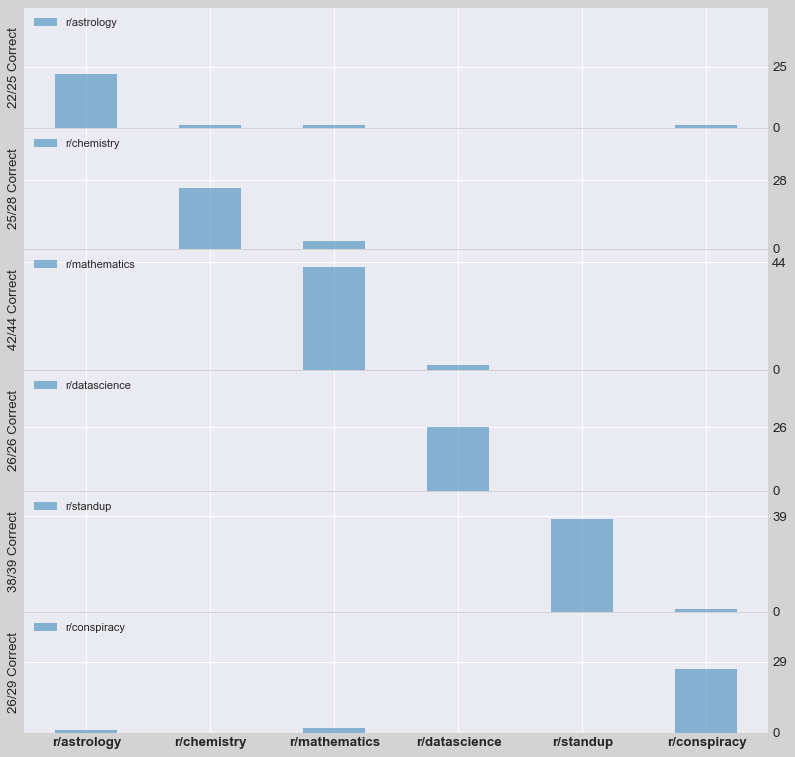

In [51]:
from matplotlib.gridspec import GridSpec as GS

# Using GridSpec to iterate over subplots
plt.figure(figsize=(12,2*len(subreddits)), dpi=80, facecolor='lightgrey')
gs = GS(ncols = 1, nrows = len(subreddits))
gs.update(hspace=0.01)#35)

# Axes for our figure
ax = [plt.subplot(gs[i]) for i, sub in enumerate(subreddits)]

# Loop over each class of data, appending relevant points to our list
for i, sub in enumerate(subreddits):
    
    # Distribution data for class of index i
    hist_list = [pr for yt, pr in zip(y_test, predict) if yt == i]
    
    # Create a subplot of the distribution
    labels, counts = np.unique(hist_list, return_counts=True)        
    ax[i].bar(labels, counts, align='center', width=0.5, alpha=0.5, label="r/"+sub)
    # Aestetic Configurations: y-axis
    ax[i].yaxis.tick_right()
    ax[i].set_yticks([0, y_test.count(i)])
    ax[i].set_yticklabels([0,y_test.count(i)],size='12')
    ax[i].set_ylim(0,max([y_test.count(j) for j, subs in enumerate(subreddits)])+5)
    ax[i].set_ylabel("{}/{} Correct".format(hist_list.count(i), y_test.count(i)), size='12')
    # Aestetic Configurations: x-axis
    ax[i].set_xticks([])
    ax[i].set_xlim(-0.5,len(subreddits)-0.5)
    ax[i].set_xticks(range(0,len(subreddits)))
    # Bottom subplot labels
    if i==len(subreddits)-1:
        ax[i].set_xticklabels(["r/{}".format(sub) for sub in subreddits], size='12', fontweight='bold')    
    ax[i].legend(loc=2)
plt.show()    

The final step now is to optimize our model by finding how many features our data should be reduced to. The following function allows for iteration of the model-fitting process 

In [52]:

def calculate_accuracy(n):
    # n_components is set to 10*<input>
    tsvd = TruncatedSVD(n_components = 10*n, n_iter = 100)
    # New matrix and test/validation sets
    X_reduced = tsvd.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, sub_labels, test_size = 0.05, random_state = 0)   
    # Fitting the model to our new data and validation-set classification
    lrcv = LogisticRegressionCV(multi_class='auto', max_iter=300, cv=5, n_jobs=2).fit(X_train,y_train) 
    predict = lrcv.predict(X_test)
    # Return rounded classifier accuracy
    return round(accuracy_score(predict, y_test), 4) 

In [53]:
# Create a list of accuracy scores 
accuracy_list = [[n, calculate_accuracy(n)] for n in range(4, 18)] 

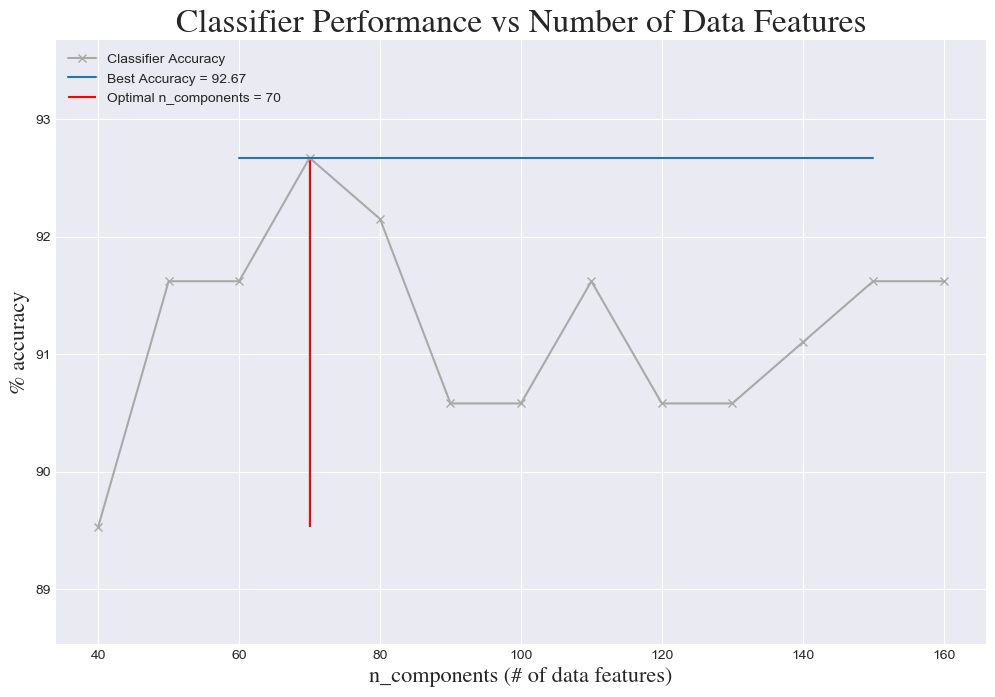

In [62]:
# Data from our accuracy calculations
x = [10*acc[0] for acc in accuracy_list]
y = [round(100*acc[1],3) for acc in accuracy_list]
vert_line = [x[i] for i, acc in enumerate(accuracy_list) if round(100*acc[1],3) == max(y)][0]

# Plot the data. along with horizontal / vertical lines showing maximum accuracy
plt.figure(figsize = (12,8), dpi=100)
plt.plot(x[:-1], y[:-1], label='Classifier Accuracy', marker='x', c='darkgray') 
plt.plot(x[2:-2], [max(y) for i in x[2:-2]], label="Best Accuracy = "+str(max(y)))
plt.vlines(x=vert_line, ymin=min(y), ymax=max(y), color='red', zorder=2, label="Optimal n_components = "+str(vert_line) ) 

# Aestetic preferences
plt.title('Classifier Performance vs Number of Data Features',size='24', fontname='Times')
plt.xlabel('n_components (# of data features)', size='16', fontname='Times')
plt.ylabel('% accuracy', size='16', fontname='Times')
plt.ylim(min(y)-1,max(y)+1)
plt.legend(loc = 2)

plt.show()